In [1]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import mne
mne.__version__
from mne.viz import plot_alignment, snapshot_brain_montage
import shutil
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split

# from mne_bids import write_raw_bids, BIDSPath, print_dir_tree, make_dataset_description
# from mne_bids.stats import count_events
import sys

from statsmodels.tsa.api import VAR



In [2]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 15 # Change the range so the process is faster

numC = 8

angles = [i * 180./numC for i in range(numC)]

x_labels = np.array(angles)

resample = False # speeds up the procees but showing worse results overall
resample_frequency = 20 # in Hz, original freq is 500Hz

In [3]:
from toolbox.methods import read_data
all_epochs, all_rawdata = read_data (task = 'main', resample=resample, amount_of_subjects=amount_of_subjects, resample_frequency=resample_frequency)

In [4]:
print(len(all_rawdata))
all_rawdata[0]['metadata'].columns

15


Index(['index', 'subj', 'nblock', 'ntrial', 'nrep', 'trial_type', 'cond-1',
       'cond', 'rDV', 'DV', 'resp', 'deci-2', 'deci-1', 'deci', 'corr-1',
       'r_map', 'correct', 'confi', 'RT', 'd1', 'conf_lvl', 'correct-1', 'd2',
       'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'confi-1',
       'conf_lvl-1'],
      dtype='object')

In [5]:
'''7min for all subjects'''

use_subject = 13

use_timepoint = False
reshape = False
timepoint = 10

X = all_rawdata[use_subject]['epoch_dat']
print(X.shape)
# X = X.reshape(X.shape[0],-1)
y = np.where(all_rawdata[use_subject]['metadata']['r_map'] == 45, 1, 0)
y2 = all_rawdata[use_subject]['metadata']['deci']
y = np.array(y)
y = all_rawdata[use_subject]['metadata']['deci']
print(y.shape)

print(X.shape, y.shape)
if use_timepoint: 
    X = X[:,:,timepoint]
else:
    if reshape:
        X = X.reshape(X.shape[0], -1)
print(X.shape, y.shape)
X = np.einsum('ijk->ikj',X)
X_eye = X[:,:,25]
X = np.delete(X, 25, axis=2)
print(X.shape, y.shape)
X = X[:,:,:]

(257, 32, 2876)
(257,)
(257, 32, 2876) (257,)
(257, 32, 2876) (257,)
(257, 2876, 31) (257,)


In [6]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

accuracy_scores = np.array([])  # Empty array to store accuracy scores

for i in range(0, 2865, 5):
    print('i = ', i)
    slide_X = X[:, i:i+10, :]
    params = np.array([VAR(slide_X[i]).fit(2).params.flatten() for i in range(X.shape[0])])
    X_train, X_test, y_train, y_test = train_test_split(params, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    accuracy_scores = np.append(accuracy_scores, score)

print(accuracy_scores)

    

i =  0
i =  5
i =  10
i =  15
i =  20
i =  25
i =  30
i =  35
i =  40
i =  45
i =  50
i =  55
i =  60
i =  65
i =  70
i =  75
i =  80
i =  85
i =  90
i =  95
i =  100
i =  105
i =  110
i =  115
i =  120
i =  125
i =  130
i =  135
i =  140
i =  145
i =  150
i =  155
i =  160
i =  165
i =  170
i =  175
i =  180
i =  185
i =  190
i =  195
i =  200
i =  205
i =  210
i =  215
i =  220
i =  225
i =  230
i =  235
i =  240
i =  245
i =  250
i =  255
i =  260
i =  265
i =  270
i =  275
i =  280
i =  285
i =  290
i =  295
i =  300
i =  305
i =  310
i =  315
i =  320
i =  325
i =  330
i =  335
i =  340
i =  345
i =  350
i =  355
i =  360
i =  365
i =  370
i =  375
i =  380
i =  385
i =  390
i =  395
i =  400
i =  405
i =  410
i =  415
i =  420
i =  425
i =  430
i =  435
i =  440
i =  445
i =  450
i =  455
i =  460
i =  465
i =  470
i =  475
i =  480
i =  485
i =  490
i =  495
i =  500
i =  505
i =  510
i =  515
i =  520
i =  525
i =  530
i =  535
i =  540
i =  545
i =  550
i =  555
i =  560
i =  

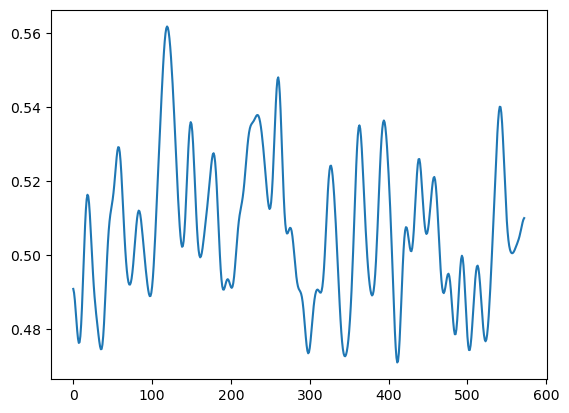

In [13]:
from scipy.ndimage import gaussian_filter
accuracy_scores = gaussian_filter(accuracy_scores, sigma=5)
plt.plot(accuracy_scores)

In [8]:
# y = np.where(all_rawdata[use_subject]['metadata']['r_map'] == 45, 1, 0)
# y2 = all_rawdata[use_subject]['metadata']['deci']
# y3 = [a ^ b for a, b in zip(y, y2)]
# print(y3)

In [9]:
params = np.array([VAR(X[i]).fit(2).params.flatten() for i in range(X.shape[0])])

In [10]:
params.shape

(257, 1953)

In [11]:
from sklearn.model_selection import train_test_split
from pyrcn.echo_state_network import ESNClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(params, y3, test_size=0.2, random_state=42)

clf = RandomForestClassifier()

# clf = CatBoostClassifier(task_type='GPU')

clf.fit(X_train, y_train)


NameError: name 'y3' is not defined

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(np.unique(y_test, return_counts=True))
print(np.unique(y_pred, return_counts=True))

              precision    recall  f1-score   support

           0       0.51      0.78      0.62        27
           1       0.33      0.13      0.19        23

    accuracy                           0.48        50
   macro avg       0.42      0.45      0.40        50
weighted avg       0.43      0.48      0.42        50

0.48
(array([0, 1]), array([27, 23]))
(array([0, 1]), array([41,  9]))


In [ ]:
arima end

In [ ]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC

def train_3(X, y, verbose=False, display_roc=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    clf = CatBoostClassifier(task_type = 'GPU')
    clf = RandomForestClassifier()
    clf = SVC()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)    
    if verbose:
        print(classification_report(y_test, y_pred))
        print(np.unique(y_test, return_counts=True))
        print(np.unique(y_pred, return_counts=True))
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    if display_roc:
        from sklearn.metrics import roc_curve
        from sklearn.metrics import RocCurveDisplay
        fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=clf.classes_[1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        return roc_display
    return accuracy, f1, roc

In [ ]:
numT = X.shape[2]
timepoint_accuracy = [None]*numT
timepoint_f1 = [None]*numT
timepoint_roc = [None]*numT
for timepoint in range(numT):
    print(timepoint)
    X_training = X[:,:,timepoint]
    timepoint_accuracy[timepoint], timepoint_f1[timepoint], timepoint_roc[timepoint] = train_3(X_training, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


KeyboardInterrupt: 

In [ ]:
print('f1 mean: ', np.mean(timepoint_f1))
print('acc mean: ', np.mean(timepoint_accuracy))
plt.plot(timepoint_f1)

# RESULTS

In [ ]:
X_training = X[:,:,1500]
print(train_3(X_training, y, verbose=True))

In [ ]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)



catboost and RF both on more data with stacked are perfoming the same

next im gonna add labels for the subjects


In [ ]:
display(all_rawdata[0]['metadata'].columns)

In [ ]:
print(multivariate)

# multivariate test?

https://pypi.org/project/pyts/

In [ ]:
from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

from pyts.datasets import load_basic_motions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)

print(X_train.shape, y_train.shape)

# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf = MultivariateClassifier(BOSSVS())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

